In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import emcee 

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut, ShuffleSplit
from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

from scipy import stats

from math import *
import sys
import re
import os
from itertools import chain

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

In [2]:
np.random.seed(0) # for reproducibility 

In [3]:
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('matplotlibrc')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
DF = pd.read_table('../regression/classical/models_cep.dat', sep='\t')
DF.drop(columns=['Mode'], inplace=True)
DF = DF[DF['M'] < 9]
pd.set_option('display.max_columns', 500)

DF['Period'] = np.log10(DF['Period'])
DF.rename(columns={'Period':'logP'}, inplace=True)

DF['W']  = DF['I_M0'] - 1.55 * (DF['V_M0'] - DF['I_M0'])
DF['VI'] = DF['V_M0'] - DF['I_M0']

DF['logR'] = np.log10(np.sqrt(10**DF['logL']) * (DF['Teff']/5777)**-2)

print(DF.columns)
DF

Index(['M', 'Z', 'logR', 'logL', 'Teff', 'logP', 'I_Amplitude', 'I_Skewness',
       'I_acuteness', 'I_R21', 'I_R31', 'I_M0', 'I_A1', 'I_A2', 'I_A3',
       'V_Amplitude', 'V_Skewness', 'V_acuteness', 'V_R21', 'V_R31', 'V_M0',
       'V_A1', 'V_A2', 'V_A3', 'W', 'VI'],
      dtype='object')


,M,Z,logR,logL,Teff,logP,I_Amplitude,I_Skewness,I_acuteness,I_R21,I_R31,I_M0,I_A1,I_A2,I_A3,V_Amplitude,V_Skewness,V_acuteness,V_R21,V_R31,V_M0,V_A1,V_A2,V_A3,W,VI
0,4.6,0.008,1.477102,3.02,6000,0.466380,0.552,2.571,1.329,0.43929,0.15010,-3.38631,0.21697,0.09531,0.03257,0.882,2.368,1.830,0.44330,0.15349,-2.74358,0.34335,0.15220,0.05270,-4.382541,0.64273
1,4.6,0.008,1.477102,3.02,6000,0.466650,0.800,3.099,1.551,0.54260,0.26072,-3.36715,0.27487,0.14915,0.07166,1.298,2.969,2.134,0.54981,0.26784,-2.71277,0.43298,0.23806,0.11597,-4.381439,0.65438
2,4.6,0.008,1.491701,3.02,5900,0.490475,0.440,2.425,0.921,0.37955,0.11013,-3.40824,0.18830,0.07147,0.02074,0.678,2.087,1.341,0.38871,0.11579,-2.73952,0.29563,0.11492,0.03423,-4.444756,0.66872
3,4.6,0.008,1.491701,3.02,5900,0.490745,0.691,3.717,1.143,0.51889,0.22975,-3.39157,0.25519,0.13242,0.05863,1.085,2.496,1.791,0.52955,0.23697,-2.71144,0.39741,0.21045,0.09417,-4.445771,0.68013
4,4.6,0.008,1.506549,3.02,5800,0.514472,0.317,1.950,0.761,0.32980,0.13680,-3.42835,0.14776,0.04873,0.02021,0.501,3.309,1.088,0.34265,0.14114,-2.73490,0.23427,0.08027,0.03307,-4.503197,0.69345
5,4.6,0.008,1.506549,3.02,5800,0.515287,0.561,3.548,0.815,0.45976,0.19837,-3.41423,0.23158,0.10647,0.04594,0.863,3.032,1.273,0.47535,0.20595,-2.70878,0.35680,0.16960,0.07348,-4.507678,0.70545
6,4.6,0.008,1.521655,3.02,5700,0.539598,0.197,2.598,0.772,0.30496,0.13906,-3.44669,0.09311,0.02840,0.01295,0.336,2.448,1.139,0.31027,0.13521,-2.72857,0.15312,0.04751,0.02070,-4.559776,0.71812
7,4.6,0.008,1.521655,3.02,5700,0.540138,0.470,9.423,0.687,0.40808,0.20670,-3.43443,0.19822,0.08089,0.04097,0.744,8.712,1.184,0.42691,0.21526,-2.70324,0.30525,0.13032,0.06571,-4.567775,0.73119
8,4.6,0.008,1.537029,3.02,5600,0.565515,0.403,7.699,0.726,0.40512,0.24458,-3.45241,0.15827,0.06412,0.03871,0.638,7.132,1.252,0.42260,0.24895,-2.69574,0.24744,0.10457,0.06160,-4.625248,0.75667
9,4.6,0.008,1.552679,3.02,5500,0.590934,0.286,4.781,0.864,0.42011,0.24556,-3.46875,0.11408,0.04793,0.02801,0.461,2.677,1.398,0.41801,0.23619,-2.68691,0.18560,0.07758,0.04384,-4.680602,0.78184


In [6]:
y_columns = ['logP', 
       'I_Amplitude', 'I_Skewness', 'I_acuteness', 
       'V_Amplitude', 'V_Skewness', 'V_acuteness', 
       'I_A1', 'I_A2', 'I_A3', 
       'V_A1', 'V_A2', 'V_A3']

X_columns = ['M', 'logR', 'logL', 'Teff', 'I_M0', 'V_M0', 'VI', 'W']

Visualize grid of models

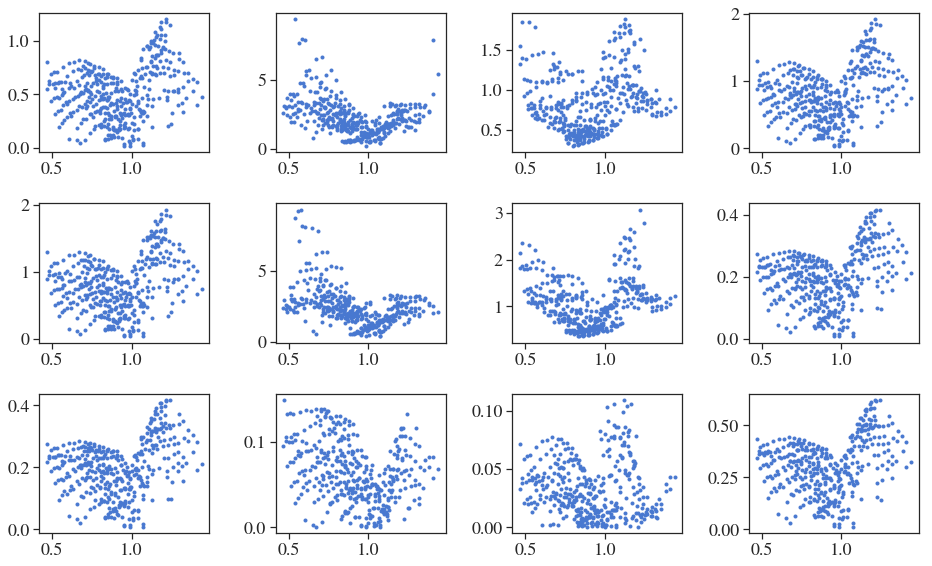

In [7]:
#sns.pairplot(DF[y_columns])
fig, ax = plt.subplots(3, 4, squeeze=True, figsize=(6.64306*2,4.10318716*2))
for i, ax_row in enumerate(ax):
    for j, axes in enumerate(ax_row):
        axes.plot(DF['logP'], DF[y_columns].iloc[:,1+3*i+j], '.')


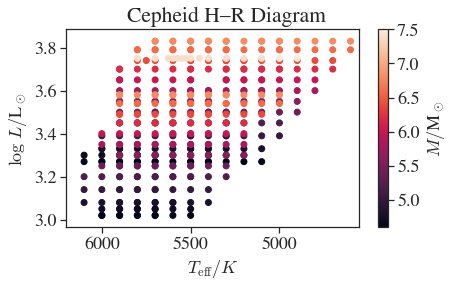

In [8]:
plt.suptitle('Cepheid H–R Diagram', y=0.99)
plt.scatter(DF['Teff'], DF['logL'], c=DF['M'])
plt.xlabel('$T_{\mathrm{eff}}/K$')
plt.ylabel('$\log\;L/$L$_\odot$')
plt.colorbar(label='$M/$M$_\odot$')
plt.xlim([6200, 4550])

plt.savefig('HR.pdf', bbox_inches='tight')
plt.show()

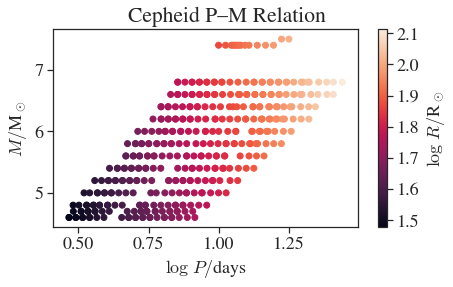

In [9]:
plt.suptitle('Cepheid P–M Relation', y=0.99)
plt.scatter(DF['logP'], DF['M'], c=DF['logR'])
plt.xlabel('$\log\;P/$days')
plt.ylabel('$M/$M$_\odot$')
plt.colorbar(label='$\log\;R/$R$_\odot$')

plt.savefig('PMR.pdf', bbox_inches='tight')
plt.show()

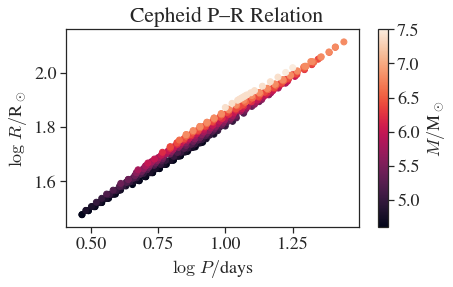

In [10]:
plt.suptitle('Cepheid P–R Relation', y=0.99)
plt.scatter(DF['logP'], DF['logR'], c=DF['M'])
plt.ylabel('$\log\;R/$R$_\odot$')
plt.xlabel('$\log\;P/$days')
plt.colorbar(label='$M/$M$_\odot$')

plt.savefig('PRM.pdf', bbox_inches='tight')
plt.show()

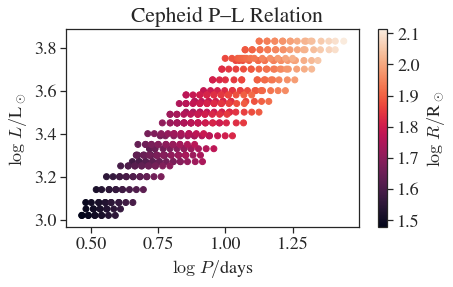

In [11]:
plt.suptitle('Cepheid P–L Relation', y=0.99)
plt.scatter(DF['logP'], DF['logL'], c=DF['logR'])
plt.ylabel('$\log\;L/$L$_\odot$')
plt.xlabel('$\log\;P/$days')
plt.colorbar(label='$\log\;R/$R$_\odot$')

plt.savefig('PL.pdf', bbox_inches='tight')
plt.show()

Leave-one-out cross validation

In [12]:
## Leave-one-out cross validation with multi-target outputs 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

ml_pred = []
ml_P_pred = []
lm_pred = []

for ii in tqdm(range(DF.shape[0])):
    ml.fit(DF.drop(ii)[y_columns], DF.drop(ii)[X_columns])
    ml_pred   += [ml.predict(DF.iloc[ii][y_columns].values.reshape(1, -1))[0]]
    
    ml.fit(DF.drop(ii)[['logP']],  DF.drop(ii)[X_columns])
    ml_P_pred += [ml.predict(DF.iloc[ii]['logP'].reshape(1, -1))[0]]
    
    lm.fit(DF.drop(ii)[['logP']],  DF.drop(ii)[X_columns])
    lm_pred   += [lm.predict(DF.iloc[ii]['logP'].reshape(1, -1))[0]]

ml_pred   = np.array(ml_pred)
ml_P_pred = np.array(ml_P_pred)
lm_pred   = np.array(lm_pred)

In [13]:
np.savetxt('NN_loo_cv-ml_pred.dat',   ml_pred)
np.savetxt('NN_loo_cv-ml_P_pred.dat', ml_P_pred)
np.savetxt('LM_loo_cv-lm_pred.dat',   lm_pred)

In [14]:
ml_pred   = np.loadtxt('NN_loo_cv-ml_pred.dat')
ml_P_pred = np.loadtxt('NN_loo_cv-ml_P_pred.dat')
lm_pred   = np.loadtxt('LM_loo_cv-lm_pred.dat')

Compute R^2 and standard deviations

In [15]:
all_r2s = []
all_sds = []

for pred in (ml_pred, lm_pred):
    
    r2s = []
    sds = []
    
    for idx, name in enumerate(X_columns):
        std = np.array(np.array(pred[:,idx]) - DF[name]).std()
        sds += [std]
        
        SS_tot = np.sum((DF[name] - DF[name].mean())**2)
        SS_res = np.sum((pred[:,idx] - DF[name].values)**2)
        R2 = 1-SS_res/SS_tot
        
        r2s += [R2]
    
    all_r2s += [r2s]
    all_sds += [sds]

all_r2s = np.array(all_r2s)
all_sds = np.array(all_sds)

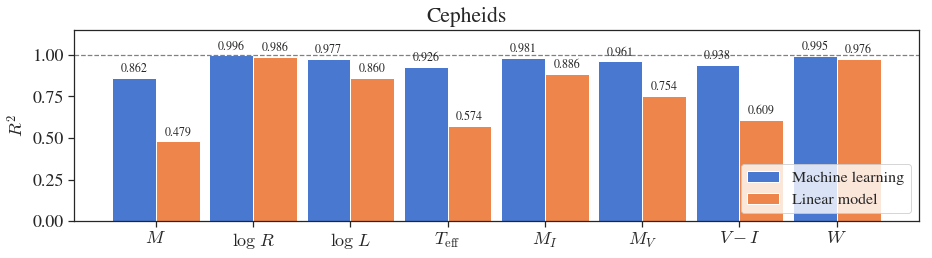

In [16]:
labels = ['$M$', '$\log\;R$', '$\log\;L$', '$T_{\\rm{eff}}$', '$M_I$', '$M_V$', '$V-I$', '$W$']

plt.rcParams["font.size"] = 18
x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(6.64306*2,4.10318716*0.9))
plt.suptitle('Cepheids', y=0.99)
rects1 = ax.bar(x - width/2, all_r2s[0,:], width, label='Machine learning')
rects2 = ax.bar(x + width/2, all_r2s[1,:], width, label='Linear model')

plt.axhline(1, c='gray', linewidth=1.25, linestyle='--')

ax.set_ylabel('$R^2$')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1.15])
ax.legend(loc='lower right')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rcParams["font.size"] = 12
autolabel(rects1)
autolabel(rects2)
plt.rcParams["font.size"] = 18
#autolabel(rects3)

plt.savefig('R2-ML-LM.pdf')
plt.show()

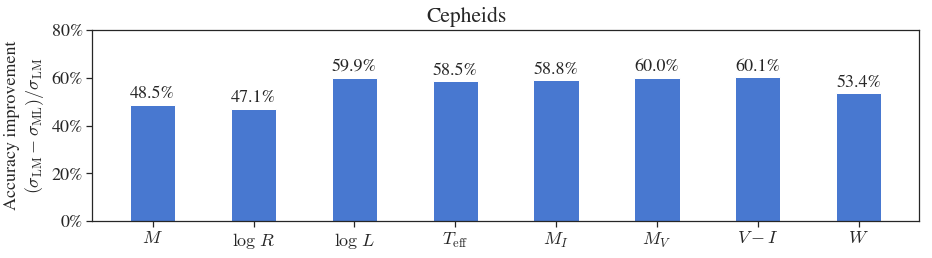

In [17]:
labels = ['$M$', '$\log\;R$', '$\log\;L$', '$T_{\\rm{eff}}$', '$M_I$', '$M_V$', '$V-I$', '$W$']

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(6.64306*2,4.10318716*0.9))
plt.suptitle('Cepheids', y=0.99)
rects1 = ax.bar(x, (all_sds[1,:] - all_sds[0,:])/all_sds[1,:], width)

ax.set_ylabel('Accuracy improvement\n$(\sigma_{\\rm{LM}} - \sigma_{\\rm{ML}}) / \sigma_{\\rm{LM}}$')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_ylim([0, 0.8])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
locs, labels = plt.yticks()
ax.set_yticklabels([str(int(loc*100)) + '%' for loc in locs])

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

plt.savefig('sds-ML-LM.pdf')
plt.show()

In [18]:
ml_stds = []
ml_r2s = []

for idx, name in enumerate(X_columns):
    std = np.array(np.array(ml_pred[:,idx]) - DF[name]).std()
    print(name, 'std: %.3f' % std)
    ml_stds += [std]
    
    SS_tot = np.sum((DF[name] - DF[name].mean())**2)
    SS_res = np.sum((ml_pred[:,idx] - DF[name].values)**2)
    R2 = 1-SS_res/SS_tot
    ml_r2s += [R2]
    
    print(name, 'R2: %.3f' % R2)

M std: 0.290
M R2: 0.862
logR std: 0.009
logR R2: 0.996
logL std: 0.034
logL R2: 0.977
Teff std: 86.309
Teff R2: 0.926
I_M0 std: 0.079
I_M0 R2: 0.981
V_M0 std: 0.103
V_M0 R2: 0.961
VI std: 0.028
VI R2: 0.938
W std: 0.049
W R2: 0.995


In [19]:
lm_stds = []
lm_r2s = []

for idx, name in enumerate(X_columns):
    std = np.array(np.array(lm_pred[:,idx]) - DF[name]).std()
    print(name, 'std: %.3f' % std)
    lm_stds += [std]
    
    SS_tot = np.sum((DF[name] - DF[name].mean())**2)
    SS_res = np.sum((lm_pred[:,idx] - DF[name].values)**2)
    R2 = 1-SS_res/SS_tot
    lm_r2s += [R2]
    
    print(name, 'R2: %.3f' % R2)

M std: 0.563
M R2: 0.479
logR std: 0.017
logR R2: 0.986
logL std: 0.084
logL R2: 0.860
Teff std: 207.785
Teff R2: 0.574
I_M0 std: 0.193
I_M0 R2: 0.886
V_M0 std: 0.257
V_M0 R2: 0.754
VI std: 0.069
VI R2: 0.609
W std: 0.105
W R2: 0.976


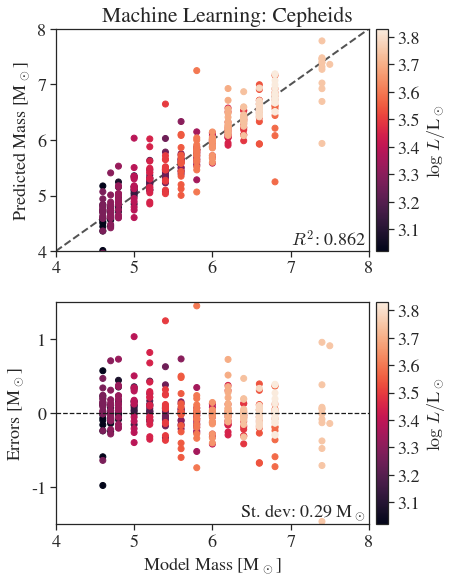

In [20]:
var = 'M'
lims = [4, 8]

plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['logL'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Mass [M$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$\log\;L/$L$_\odot$', pad=0.02)
plt.text(7, 4.1, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.axhline(0, c='k', ls='--', linewidth=1.25)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)] - DF[var], c=DF['logL'])
plt.xlabel('Model Mass [M$_\odot$]')
plt.ylabel('Errors [M$_\odot$]')
plt.colorbar(label='$\log\;L/$L$_\odot$', pad=0.02)
plt.xlim(lims)
plt.ylim([-1.5, 1.5])
ax2.set_yticks([-1, 0, 1])
ax2.set_yticklabels([-1, 0, 1])
plt.text(6.35, -1.4, 'St. dev: %.2f M$_\odot$' % ml_stds[X_columns.index(var)])

plt.savefig('CEP-ML-mass.pdf')#, bbox_inches='tight')
plt.show()

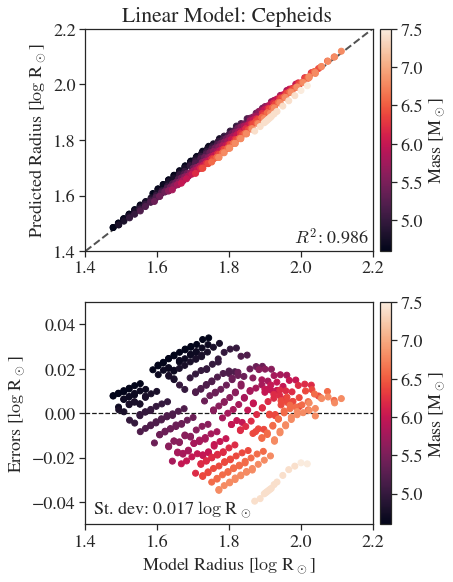

In [21]:
var = 'logR'
lims = [1.4, 2.2]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Linear Model: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)], c=DF['M'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Radius [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.text(1.98, 1.43, '$R^2$: %.3f' % lm_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)] - DF[var], c=DF['M'])
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.xlabel('Model Radius [$\log$ R$_\odot$]')
plt.ylabel('Errors [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.05, 0.05])
plt.text(1.42, -0.045, 'St. dev: %.3f $\log$ R$_\odot$' % lm_stds[X_columns.index(var)])

plt.savefig('CEP-LM-radius.pdf')#, bbox_inches='tight')
plt.show()

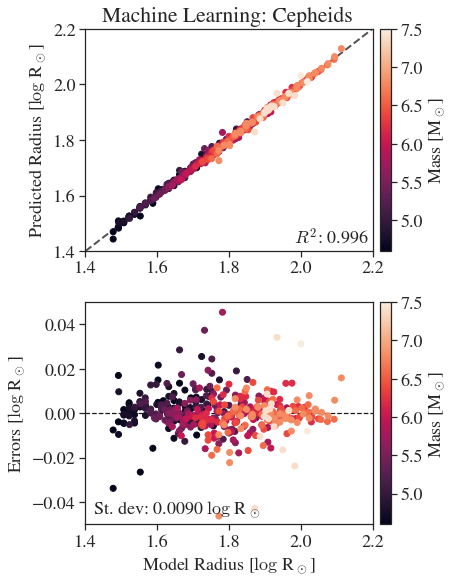

In [22]:
var = 'logR'
lims = [1.4, 2.2]

plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['M'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Radius [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.text(1.98, 1.43, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)] - DF[var], c=DF['M'])
plt.colorbar(label='Mass [M$_\odot$]', pad=0.02)
plt.xlabel('Model Radius [$\log$ R$_\odot$]')
plt.ylabel('Errors [$\log$ R$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.05, 0.05])
plt.text(1.42, -0.045, 'St. dev: %.4f $\log$ R$_\odot$' % ml_stds[X_columns.index(var)])

plt.savefig('CEP-ML-radius.pdf')#, bbox_inches='tight')
plt.show()

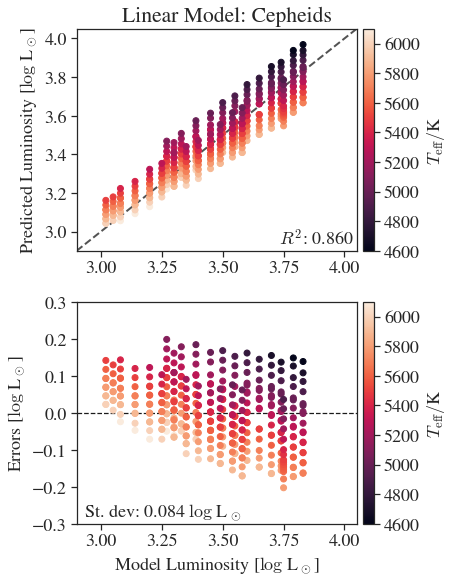

In [23]:
var = 'logL'
lims = [2.9, 4.05]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Linear Model: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Luminosity [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(3.73, 2.93, '$R^2$: %.3f' % lm_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF['logL'], lm_pred[:,X_columns.index(var)] - DF['logL'], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model Luminosity [$\log$ L$_\odot$]')
plt.ylabel('Errors [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.3, 0.3])
plt.text(2.93, -0.28, 'St. dev: %.3f $\log$ L$_\odot$' % lm_stds[X_columns.index(var)])

plt.savefig('CEP-LM-luminosity.pdf')#, bbox_inches='tight')
plt.show()

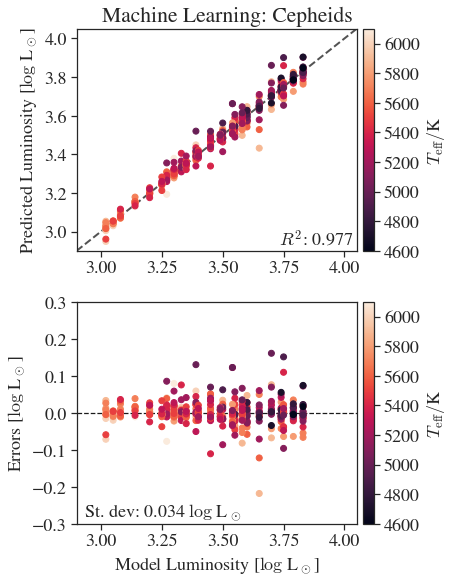

In [24]:
lims = [2.9, 4.05]

plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Luminosity [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(3.73, 2.93, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF['logL'], ml_pred[:,X_columns.index(var)] - DF['logL'], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model Luminosity [$\log$ L$_\odot$]')
plt.ylabel('Errors [$\log$ L$_\odot$]')
plt.xlim(lims)
plt.ylim([-0.3, 0.3])
plt.text(2.93, -0.28, 'St. dev: %.3f $\log$ L$_\odot$' % ml_stds[X_columns.index(var)])

plt.savefig('CEP-ML-luminosity.pdf')#, bbox_inches='tight')
plt.show()

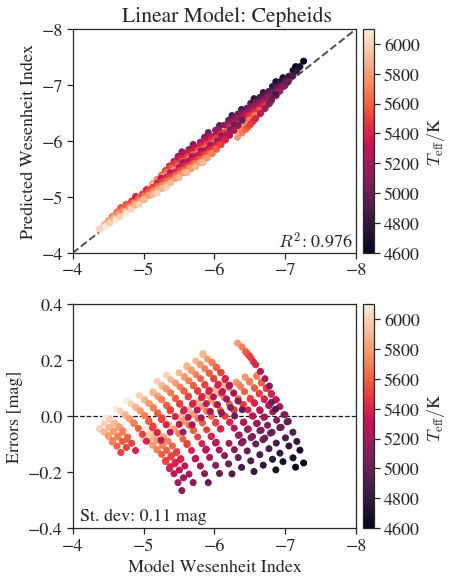

In [25]:
var = 'W'
lims = [-4, -8]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Linear Model: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Wesenheit Index')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(-6.9, -4.1, '$R^2$: %.3f' % lm_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], lm_pred[:,X_columns.index(var)] - DF[var], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model Wesenheit Index')
plt.ylabel('Errors [mag]')
plt.xlim(lims)
plt.ylim([-0.4, 0.4])
plt.text(-4.1, -0.37, 'St. dev: %.2f mag' % lm_stds[X_columns.index(var)])

plt.savefig('CEP-LM-W.pdf')#, bbox_inches='tight')
plt.show()

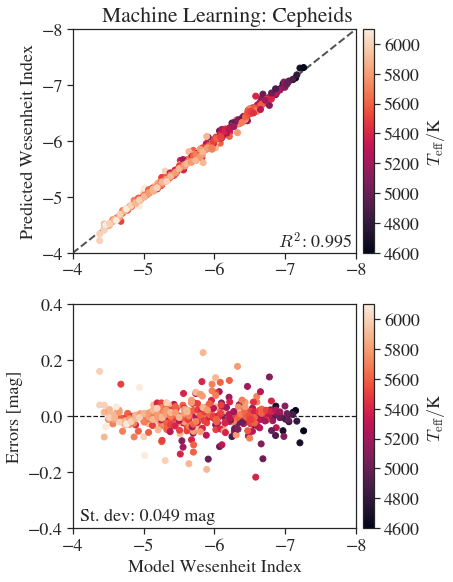

In [26]:
var = 'W'
lims = [-4, -8]

fig = plt.figure(figsize=(6.64306,4.10318716*2))
plt.suptitle('Machine Learning: Cepheids', y=0.995)

ax = plt.subplot(2,1,1)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)], c=DF['Teff'])
plt.plot([lims[0],lims[1]], [lims[0],lims[1]], 'k--', alpha=0.75, zorder=0)
plt.ylabel('Predicted Wesenheit Index')
plt.xlim(lims)
plt.ylim(lims)
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.text(-6.9, -4.1, '$R^2$: %.3f' % ml_r2s[X_columns.index(var)])

ax2 = plt.subplot(2,1,2, sharex=ax)
plt.plot([lims[0], lims[1]], [0, 0], 'k--', zorder=0, linewidth=1.25)
plt.scatter(DF[var], ml_pred[:,X_columns.index(var)] - DF[var], c=DF['Teff'])
plt.colorbar(label='$T_{\\rm{eff}}/$K', pad=0.02)
plt.xlabel('Model Wesenheit Index')
plt.ylabel('Errors [mag]')
plt.xlim(lims)
plt.ylim([-0.4, 0.4])
plt.text(-4.1, -0.37, 'St. dev: %.3f mag' % ml_stds[X_columns.index(var)])

plt.savefig('CEP-ML-W.pdf')#, bbox_inches='tight')
plt.show()

Significance testing

In [27]:
# (neural network with log P and lightcurve) vs (linear model with log P)

np.random.seed(0) 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

first_p1 = 0 
s2s = []

for ii in range(5):
    ml_scores = []
    lm_scores = []
    
    cv = ShuffleSplit(n_splits=2, random_state=ii, train_size=0.5, test_size=0.5)
    
    for train_index, test_index in cv.split(DF):
        ml.fit(DF.iloc[train_index][y_columns], DF.iloc[train_index][X_columns])
        lm.fit(DF.iloc[train_index][['logP']],  DF.iloc[train_index][X_columns])
        
        ml_predict = ml.predict(DF.iloc[test_index][y_columns])
        lm_predict = lm.predict(DF.iloc[test_index][['logP']])
        
        ml_scores_ = []
        lm_scores_ = []
        
        for idx, name in enumerate(X_columns):
            SS_tot = np.sum((DF.iloc[test_index][name] - DF.iloc[test_index][name].mean())**2)
            
            ml_SS_res = np.sum((ml_predict[:,idx] - DF.iloc[test_index][name].values)**2)
            ml_R2 = 1-ml_SS_res/SS_tot
            ml_scores_ += [ml_R2]
            
            lm_SS_res = np.sum((lm_predict[:,idx] - DF.iloc[test_index][name].values)**2)
            lm_R2 = 1-lm_SS_res/SS_tot
            lm_scores_ += [lm_R2]
        
        ml_scores += [ml_scores_]
        lm_scores += [lm_scores_]
    
    ml_scores = np.array(ml_scores)
    lm_scores = np.array(lm_scores)
    
    p1 = ml_scores[0,:] - lm_scores[0,:]
    p2 = ml_scores[1,:] - lm_scores[1,:]
    p_bar = (p1 + p2)/2
    s2 = (p1 - p_bar)**2 + (p2 - p_bar)**2
    
    if ii == 0:
        first_p1 = p1
    s2s += [s2]

first_p1 = np.array(first_p1)
s2s = np.array(s2s)

for idx, name in enumerate(X_columns):
    p = stats.t.sf(np.abs(first_p1[idx]) / np.sqrt(1/5. * sum(s2s[:,idx])), 5)*2.
    print(name, '%.10f' % p)

M 0.0002812398
logR 0.0042456677
logL 0.0000123332
Teff 0.0000979542
I_M0 0.0000246174
V_M0 0.0000091307
VI 0.0001188387
W 0.0002062426


In [28]:
# (neural network with log P and lightcurve) vs (linear model with log P and lightcurve)

np.random.seed(0) 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

first_p1 = 0 
s2s = []

for ii in range(5):
    ml_scores = []
    lm_scores = []
    
    cv = ShuffleSplit(n_splits=2, random_state=ii, train_size=0.5, test_size=0.5)
    
    for train_index, test_index in cv.split(DF):
        ml.fit(DF.iloc[train_index][y_columns], DF.iloc[train_index][X_columns])
        lm.fit(DF.iloc[train_index][y_columns], DF.iloc[train_index][X_columns])
        
        ml_predict = ml.predict(DF.iloc[test_index][y_columns])
        lm_predict = lm.predict(DF.iloc[test_index][y_columns])
        
        ml_scores_ = []
        lm_scores_ = []
        
        for idx, name in enumerate(X_columns):
            SS_tot = np.sum((DF.iloc[test_index][name] - DF.iloc[test_index][name].mean())**2)
            
            ml_SS_res = np.sum((ml_predict[:,idx] - DF.iloc[test_index][name].values)**2)
            ml_R2 = 1-ml_SS_res/SS_tot
            ml_scores_ += [ml_R2]
            
            lm_SS_res = np.sum((lm_predict[:,idx] - DF.iloc[test_index][name].values)**2)
            lm_R2 = 1-lm_SS_res/SS_tot
            lm_scores_ += [lm_R2]
        
        ml_scores += [ml_scores_]
        lm_scores += [lm_scores_]
    
    ml_scores = np.array(ml_scores)
    lm_scores = np.array(lm_scores)
    
    p1 = ml_scores[0,:] - lm_scores[0,:]
    p2 = ml_scores[1,:] - lm_scores[1,:]
    p_bar = (p1 + p2)/2
    s2 = (p1 - p_bar)**2 + (p2 - p_bar)**2
    
    if ii == 0:
        first_p1 = p1
    s2s += [s2]

first_p1 = np.array(first_p1)
s2s = np.array(s2s)

for idx, name in enumerate(X_columns):
    p = stats.t.sf(np.abs(first_p1[idx]) / np.sqrt(1/5. * sum(s2s[:,idx])), 5)*2.
    print(name, '%.10f' % p)

M 0.0017278439
logR 0.0117370732
logL 0.0011090103
Teff 0.0008142357
I_M0 0.0018426680
V_M0 0.0013384846
VI 0.0003815986
W 0.0011087776


Now train on all models and run on real data 

In [29]:
np.random.seed(0) 

ml = TransformedTargetRegressor(regressor=Pipeline(
            [('scaler', RobustScaler()), 
             ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), 
                                  max_iter=2000, activation='relu', solver='lbfgs', tol=1e-7))]),
         transformer=RobustScaler())
lm = LinearRegression()

ml.fit(DF[y_columns], DF[X_columns])
lm.fit(DF[['logP']], DF[X_columns])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [30]:
maxs = DF[y_columns].quantile(0.95)
mins = DF[y_columns].quantile(0.05)
#print(maxs, mins)

In [31]:
X_maxs = DF[X_columns].max()#quantile(0.95)
X_mins = DF[X_columns].min()#quantile(0.05)
#print(X_maxs, X_mins)

In [32]:
star_names = []
ests = []
e_ests = []
logPs = []

lm_ests = []
e_lm_ests = []

LMC_CEP_dir = '/scratch/seismo/bellinger/asteroseismology/regression/perturb/LMC_CEP'
for star_filename in tqdm(os.listdir(LMC_CEP_dir)):
    star_name = star_filename.split('_')[0]
    star_data = pd.read_table(os.path.join(LMC_CEP_dir, star_filename), sep='\s+')
    star_data['Period'] = np.log10(star_data['Period'])
    star_data.rename(columns={'Period':'logP'}, inplace=True)
    
    if np.any(star_data[y_columns] >= maxs) or np.any(star_data[y_columns] <= mins):
        #print('Skipping', star_name)
        continue 
    
    res = ml.predict(star_data[y_columns])
    
    if np.any([res_i >= X_maxs for res_i in res]) or \
       np.any([res_i <= X_mins for res_i in res]):
        #print('Skipping', star_name)
        continue
    
    ests += [res[0]]
    e_ests += [res.std(axis=0)]
    
    lm_res = lm.predict(star_data[['logP']])
    lm_ests += [lm_res[0]]
    e_lm_ests += [lm_res.std(axis=0)]
    
    star_names += [star_name]
    logPs += [star_data['logP'].iloc[0]]

logPs = np.array(logPs)

ests = np.array(ests)
e_ests = np.array(e_ests)

lm_ests = np.array(lm_ests)
e_lm_ests = np.array(e_lm_ests)

In [33]:
ests.shape

(325, 8)

In [34]:
e_ests_ = np.array([np.sqrt(e_ests[ii]**2 + np.array(ml_stds)**2) 
                    for ii in range(len(e_ests))])

In [35]:
ests_ = np.vstack(chain.from_iterable(((ests[:,ii], e_ests_[:,ii]) for ii in range(ests.shape[1])))).T

In [36]:
#ests_DF = pd.DataFrame(ests, columns=X_columns)
ests_DF = pd.DataFrame(ests_, columns=list(chain.from_iterable(zip(X_columns, ['e_'+X_col for X_col in X_columns]))))
ests_DF.insert(0, 'ID', star_names)
ests_DF

,ID,M,e_M,logR,e_logR,logL,e_logL,Teff,e_Teff,I_M0,e_I_M0,V_M0,e_V_M0,VI,e_VI,W,e_W
0,OGLE-LMC-CEP-0033,5.981732,0.337726,1.756617,0.012378,3.513580,0.049655,5784.480902,121.009577,-4.660956,0.117356,-3.963571,0.154273,0.700211,0.039913,-5.748440,0.071382
1,OGLE-LMC-CEP-0050,6.166502,0.348331,1.780000,0.012193,3.541317,0.051016,5719.021219,123.574670,-4.744733,0.118424,-4.020167,0.158446,0.720711,0.041439,-5.862415,0.070816
2,OGLE-LMC-CEP-0057,6.871249,0.347063,1.861168,0.009696,3.693657,0.033855,5684.717505,90.310409,-5.148841,0.079728,-4.423182,0.103706,0.721185,0.028923,-6.260633,0.051031
3,OGLE-LMC-CEP-0078,5.699958,0.310069,1.749439,0.009997,3.493068,0.034951,5763.870880,88.774420,-4.608432,0.083191,-3.901637,0.107049,0.708586,0.028518,-5.707185,0.053806
4,OGLE-LMC-CEP-0103,6.330912,0.353034,1.760601,0.012093,3.570397,0.039056,5941.385137,88.321275,-4.794215,0.093167,-4.144789,0.116583,0.647057,0.028399,-5.795697,0.064964
5,OGLE-LMC-CEP-0107,5.980849,0.296642,1.799100,0.009636,3.584044,0.041442,5732.983831,104.061549,-4.840953,0.096052,-4.120565,0.127145,0.720462,0.033722,-5.961329,0.055855
6,OGLE-LMC-CEP-0123,5.826094,0.302649,1.736962,0.009948,3.461769,0.035945,5738.516324,91.562283,-4.529634,0.085612,-3.816418,0.110873,0.716085,0.029630,-5.639910,0.054166
7,OGLE-LMC-CEP-0155,6.250097,0.339739,1.835071,0.010187,3.702338,0.034461,5870.056191,89.020958,-5.143550,0.081944,-4.480868,0.105025,0.665213,0.028477,-6.182993,0.054365
8,OGLE-LMC-CEP-0158,5.487512,0.324787,1.735524,0.010998,3.476436,0.037912,5801.943364,90.927116,-4.557389,0.090165,-3.861329,0.114878,0.698613,0.029261,-5.643501,0.059855
9,OGLE-LMC-CEP-0162,5.465754,0.467680,1.647071,0.017370,3.367102,0.044205,6015.969035,86.728966,-4.252390,0.111135,-3.626834,0.130222,0.629550,0.027844,-5.230378,0.090481


In [37]:
ests_DF.iloc[1:10].to_latex(longtable=False, index=False)

'\\begin{tabular}{lrrrrrrrrrrrrrrrr}\n\\toprule\n                ID &         M &       e\\_M &      logR &    e\\_logR &      logL &    e\\_logL &         Teff &      e\\_Teff &      I\\_M0 &    e\\_I\\_M0 &      V\\_M0 &    e\\_V\\_M0 &        VI &      e\\_VI &         W &       e\\_W \\\\\n\\midrule\n OGLE-LMC-CEP-0050 &  6.166502 &  0.348331 &  1.780000 &  0.012193 &  3.541317 &  0.051016 &  5719.021219 &  123.574670 & -4.744733 &  0.118424 & -4.020167 &  0.158446 &  0.720711 &  0.041439 & -5.862415 &  0.070816 \\\\\n OGLE-LMC-CEP-0057 &  6.871249 &  0.347063 &  1.861168 &  0.009696 &  3.693657 &  0.033855 &  5684.717505 &   90.310409 & -5.148841 &  0.079728 & -4.423182 &  0.103706 &  0.721185 &  0.028923 & -6.260633 &  0.051031 \\\\\n OGLE-LMC-CEP-0078 &  5.699958 &  0.310069 &  1.749439 &  0.009997 &  3.493068 &  0.034951 &  5763.870880 &   88.774420 & -4.608432 &  0.083191 & -3.901637 &  0.107049 &  0.708586 &  0.028518 & -5.707185 &  0.053806 \\\\\n OGLE-LMC-CEP-0103 &  6.3309

In [38]:
def signif(x, digits=6):
    if x == 0 or not isfinite(x):
        return x
    digits -= ceil(log10(abs(x)))
    rounded = round(x, digits)
    if rounded > 10:
        rounded = int(rounded)
    return rounded

def formatter(val, unc):
    unc = str(signif(unc, 2))
    if len(unc) == 1:
        unc += '.0'
    if float(unc) < 10:
        if unc[-2] == '0' or (unc[-2] == '.' and unc[-3] == '0'):
            unc += '0'
        dec_places = len(unc.split('.')[1])
        val = str(val).split('.')
        val = val[0] + '.' + val[1][:dec_places]
    else:
        val = str(val).split('.')[0]
        if len(unc) > 2:
            val = val[:len(val) - len(unc) + 2] + '0'*(len(val) - len(unc))
    return [val, unc]


In [39]:
for index, row in ests_DF.iloc[0:10].iterrows():
    out_str = row['ID'].split('-')[-1]
    
    rest = row[1:]
    for ii in range(len(rest) - 1):
        if ii % 2 != 0: # every other column contains the uncertainty 
            continue
        
        val, unc = formatter(rest[ii], rest[ii+1])
        out_str += ' & ' + val + ' $\pm$ ' + unc
    
    out_str += r' \\'
    
    print(out_str)

0033 & 5.98 $\pm$ 0.34 & 1.756 $\pm$ 0.012 & 3.513 $\pm$ 0.050 & 5780 $\pm$ 120 & -4.66 $\pm$ 0.12 & -3.96 $\pm$ 0.15 & 0.700 $\pm$ 0.040 & -5.748 $\pm$ 0.071 \\
0050 & 6.16 $\pm$ 0.35 & 1.780 $\pm$ 0.012 & 3.541 $\pm$ 0.051 & 5710 $\pm$ 120 & -4.74 $\pm$ 0.12 & -4.02 $\pm$ 0.16 & 0.720 $\pm$ 0.041 & -5.862 $\pm$ 0.071 \\
0057 & 6.87 $\pm$ 0.35 & 1.8611 $\pm$ 0.0097 & 3.693 $\pm$ 0.034 & 5684 $\pm$ 90 & -5.148 $\pm$ 0.080 & -4.42 $\pm$ 0.10 & 0.721 $\pm$ 0.029 & -6.260 $\pm$ 0.051 \\
0078 & 5.69 $\pm$ 0.31 & 1.749 $\pm$ 0.010 & 3.493 $\pm$ 0.035 & 5763 $\pm$ 89 & -4.608 $\pm$ 0.083 & -3.90 $\pm$ 0.11 & 0.708 $\pm$ 0.029 & -5.707 $\pm$ 0.054 \\
0103 & 6.33 $\pm$ 0.35 & 1.760 $\pm$ 0.012 & 3.570 $\pm$ 0.039 & 5941 $\pm$ 88 & -4.794 $\pm$ 0.093 & -4.14 $\pm$ 0.12 & 0.647 $\pm$ 0.028 & -5.795 $\pm$ 0.065 \\
0107 & 5.98 $\pm$ 0.30 & 1.7990 $\pm$ 0.0096 & 3.584 $\pm$ 0.041 & 5730 $\pm$ 100 & -4.840 $\pm$ 0.096 & -4.12 $\pm$ 0.13 & 0.720 $\pm$ 0.034 & -5.961 $\pm$ 0.056 \\
0123 & 5.82 $\pm$ 0

In [40]:
out_str = '\t'.join(list(ests_DF.columns)) + '\n'
for index, row in ests_DF.iterrows():
    out_str += row['ID'] + '\t'
    
    rest = row[1:]
    for ii in range(len(rest) - 1):
        if ii % 2 != 0: # every other column contains the uncertainty 
            continue
        
        val, unc = formatter(rest[ii], rest[ii+1])
        out_str += val + '\t' + unc + '\t'
    
    out_str += '\n'
    
print(out_str)

out_file = open("ML-OGLE_LMC_CEP.dat", "w")
out_file.write(out_str)
out_file.close()

ID	M	e_M	logR	e_logR	logL	e_logL	Teff	e_Teff	I_M0	e_I_M0	V_M0	e_V_M0	VI	e_VI	W	e_W
OGLE-LMC-CEP-0033	5.98	0.34	1.756	0.012	3.513	0.050	5780	120	-4.66	0.12	-3.96	0.15	0.700	0.040	-5.748	0.071	
OGLE-LMC-CEP-0050	6.16	0.35	1.780	0.012	3.541	0.051	5710	120	-4.74	0.12	-4.02	0.16	0.720	0.041	-5.862	0.071	
OGLE-LMC-CEP-0057	6.87	0.35	1.8611	0.0097	3.693	0.034	5684	90	-5.148	0.080	-4.42	0.10	0.721	0.029	-6.260	0.051	
OGLE-LMC-CEP-0078	5.69	0.31	1.749	0.010	3.493	0.035	5763	89	-4.608	0.083	-3.90	0.11	0.708	0.029	-5.707	0.054	
OGLE-LMC-CEP-0103	6.33	0.35	1.760	0.012	3.570	0.039	5941	88	-4.794	0.093	-4.14	0.12	0.647	0.028	-5.795	0.065	
OGLE-LMC-CEP-0107	5.98	0.30	1.7990	0.0096	3.584	0.041	5730	100	-4.840	0.096	-4.12	0.13	0.720	0.034	-5.961	0.056	
OGLE-LMC-CEP-0123	5.82	0.30	1.7369	0.0099	3.461	0.036	5738	92	-4.529	0.086	-3.81	0.11	0.716	0.030	-5.639	0.054	
OGLE-LMC-CEP-0155	6.25	0.34	1.835	0.010	3.702	0.034	5870	89	-5.143	0.082	-4.48	0.11	0.665	0.028	-6.182	0.054	
OGLE-LMC-CEP-0158	5.48	0.32	1.73

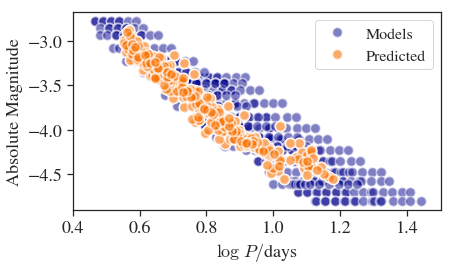

In [41]:
var = 'logL'
mew = 1.8
ms = 20
plt.plot(DF['logP'], -2.5*DF[var].values + 4.77, '.', 
         mfc='white', mec='white', mew=mew, alpha=1, ms=ms)
plt.plot(DF['logP'], -2.5*DF[var].values + 4.77, '.', label='Models', 
         mfc='darkblue', mec='white', mew=mew, alpha=0.5, ms=ms)
plt.plot(logPs, -2.5*ests[:,X_columns.index(var)] + 4.77, '.', 
         mfc='white', mec='white', mew=mew, alpha=1, ms=ms)
plt.plot(logPs, -2.5*ests[:,X_columns.index(var)] + 4.77, '.', label='Predicted', 
         mfc='#F97100', mec='white', mew=mew, alpha=0.6, ms=ms)
plt.xlabel('$\log\;P/$days')
plt.ylabel('Absolute Magnitude')
#plt.ylabel('$\log\;L/$L$_\odot$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-PM-predicted.pdf')#, bbox_inches='tight')
plt.show()

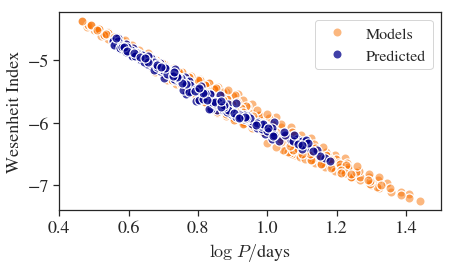

In [42]:
var = 'W'
mew = 1.4
ms = 18
for idx, star in DF.sample(frac=1, random_state=0).iterrows():
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', 
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms, label='')
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', label='Models' if idx == 1 else '', 
             mfc='#F97100', mec='None', mew=mew, alpha=0.5, ms=ms-2)
for ii in range(len(logPs)):
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='Predicted' if ii == 1 else '', 
             mfc='darkblue', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('Wesenheit Index')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-W.pdf')#, bbox_inches='tight')
plt.show()

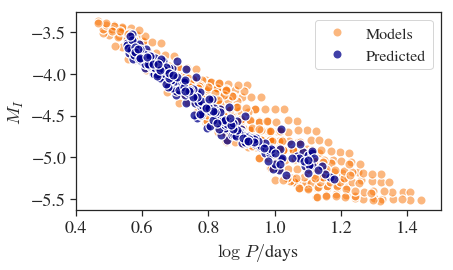

In [43]:
var = 'I_M0'
mew = 1.4
ms = 18
for idx, star in DF.sample(frac=1, random_state=0).iterrows():
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', 
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms, label='')
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', label='Models' if idx == 1 else '', 
             mfc='#F97100', mec='None', mew=mew, alpha=0.5, ms=ms-2)
for ii in range(len(logPs)):
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='Predicted' if ii == 1 else '', 
             mfc='darkblue', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('$M_I$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-I.pdf')#, bbox_inches='tight')
plt.show()

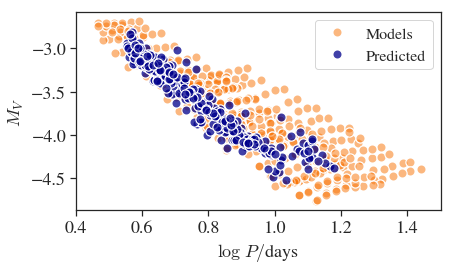

In [44]:
var = 'V_M0'
mew = 1.4
ms = 18
for idx, star in DF.sample(frac=1, random_state=0).iterrows():
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', 
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms, label='')
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', label='Models' if idx == 1 else '', 
             mfc='#F97100', mec='None', mew=mew, alpha=0.5, ms=ms-2)
for ii in range(len(logPs)):
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='Predicted' if ii == 1 else '', 
             mfc='darkblue', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('$M_V$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-V.pdf')#, bbox_inches='tight')
plt.show()

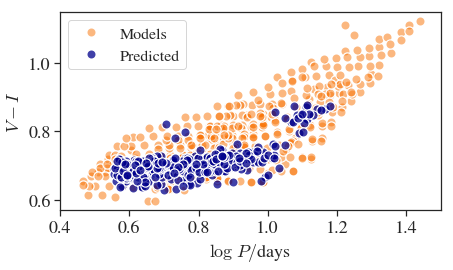

In [45]:
var = 'VI'
mew = 1.4
ms = 18
for idx, star in DF.sample(frac=1, random_state=0).iterrows():
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', 
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms, label='')
    plt.plot(DF['logP'].iloc[idx], DF[var].iloc[idx], '.', label='Models' if idx == 1 else '', 
             mfc='#F97100', mec='None', mew=mew, alpha=0.5, ms=ms-2)
for ii in range(len(logPs)):
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], ests[:,X_columns.index(var)][ii], '.', label='Predicted' if ii == 1 else '', 
             mfc='darkblue', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('$V - I$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-VI.pdf')#, bbox_inches='tight')
plt.show()

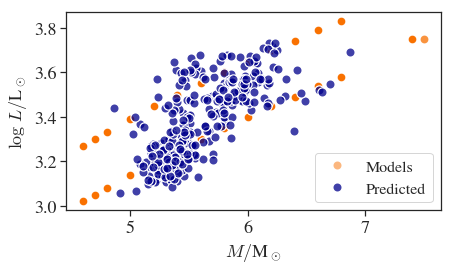

In [46]:
var = 'logL'
mew = 1.4
ms = 18
for idx, star in DF.sample(frac=1, random_state=0).iterrows():
    plt.plot(DF['M'].iloc[idx], DF[var].iloc[idx], '.', 
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms, label='')
    plt.plot(DF['M'].iloc[idx], DF[var].iloc[idx], '.', label='Models' if idx == 1 else '', 
             mfc='#F97100', mec='None', mew=mew, alpha=0.5, ms=ms-2)
for ii in range(len(logPs)):
    plt.plot(ests[:,X_columns.index('M')][ii], ests[:,X_columns.index(var)][ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(ests[:,X_columns.index('M')][ii], ests[:,X_columns.index(var)][ii], '.', label='Predicted' if ii == 1 else '', 
             mfc='darkblue', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.ylabel('$\log\;L/$L$_\odot$')
plt.xlabel('$M/$M$_\odot$')
plt.legend(loc='best')
#plt.xlim([0.4, 1.5])
#plt.savefig('CEP-LMC-VI.pdf')#, bbox_inches='tight')
plt.show()

Compare with observations 

In [47]:
V_data = pd.read_table('/scratch/seismo/bellinger/asteroseismology/regression/classical/data/cep_lmc_v.dat', sep='\s+')
I_data = pd.read_table('/scratch/seismo/bellinger/asteroseismology/regression/classical/data/cep_lmc_i.dat', sep='\s+')
evi_data = pd.read_table('evi_lmc_ceph.dat', sep='\s+')

In [48]:
ev_mean_val = evi_data['ev_i'].mean()

In [49]:
from uncertainties import ufloat

actual_Ws = []
e_actual_Ws = []
actual_Is = []
actual_Vs = []
actual_VIs = []
for star_name in tqdm(star_names):
    V = ufloat(V_data[V_data['ID'] == star_name]['A0'].iloc[0], V_data[V_data['ID'] == star_name]['eA0'].iloc[0])
    I = ufloat(I_data[I_data['ID'] == star_name]['A0'].iloc[0], I_data[I_data['ID'] == star_name]['eA0'].iloc[0])
    W = I - 1.55 * (V-I)
    actual_Ws += [W.nominal_value]
    e_actual_Ws += [W.std_dev]
    
    ev = evi_data[evi_data['id'] == star_name]
    if ev.shape[0] == 0:
        ev = ev_mean_val
    else:
        ev = ev.iloc[0]['ev_i']
    #A_V = 2.4*E(V-I)
    #A_I = 1.41*E(V-I)
    actual_Is += [I.nominal_value - 1.41*ev]
    actual_Vs += [V.nominal_value - 2.4*ev]
    actual_VIs += [(V-I).nominal_value]

actual_Ws = np.array(actual_Ws)
e_actual_Ws = np.array(e_actual_Ws)
actual_Is = np.array(actual_Is)
actual_Vs = np.array(actual_Vs)
actual_VIs = np.array(actual_VIs)

In [50]:
mew = 1.4 # marker edge width
ms = 18 # marker size 

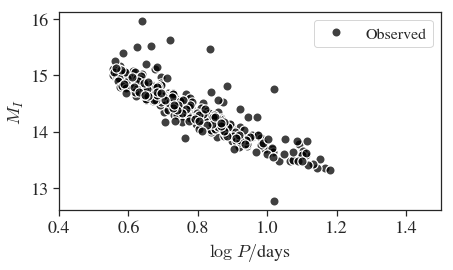

In [51]:
for ii in range(len(logPs)):
    plt.plot(logPs[ii], actual_Is[ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], actual_Is[ii], '.', label='Observed' if ii == 1 else '', 
             mfc='#000000', mec='None', mew=mew, alpha=0.75, ms=ms-2)

plt.xlabel('$\log\;P/$days')
plt.ylabel('$M_I$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-I-obs.pdf')#, bbox_inches='tight')
plt.show()

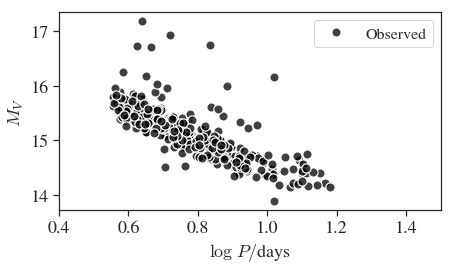

In [52]:
for ii in range(len(logPs)):
    plt.plot(logPs[ii], actual_Vs[ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], actual_Vs[ii], '.', label='Observed' if ii == 1 else '', 
             mfc='#000000', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('$M_V$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-V-obs.pdf')
plt.show()

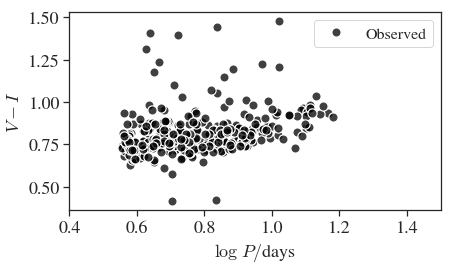

In [53]:
for ii in range(len(logPs)):
    plt.plot(logPs[ii], actual_VIs[ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], actual_VIs[ii], '.', label='Observed' if ii == 1 else '', 
             mfc='#000000', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('$V-I$')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-VI-obs.pdf')#, bbox_inches='tight')
plt.show()

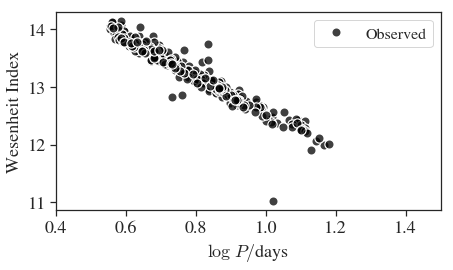

In [54]:
for ii in range(len(logPs)):
    plt.plot(logPs[ii], actual_Ws[ii], '.', label='',
             mfc='None', mec='white', mew=mew, alpha=1, ms=ms)
    plt.plot(logPs[ii], actual_Ws[ii], '.', label='Observed' if ii == 1 else '', 
             mfc='#000000', mec='None', mew=mew, alpha=0.75, ms=ms-2)
plt.xlabel('$\log\;P/$days')
plt.ylabel('Wesenheit Index')
plt.legend(loc='best')
plt.xlim([0.4, 1.5])
plt.savefig('CEP-LMC-W-obs.pdf')#, bbox_inches='tight')
plt.show()

Estimate distances 

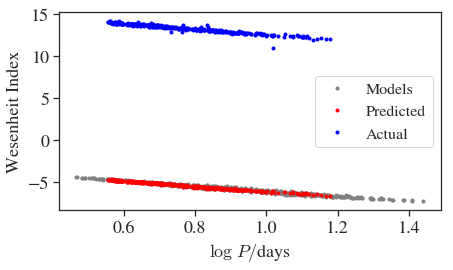

In [55]:
plt.plot(DF['logP'], DF['W'], '.', c='gray', label='Models')
plt.plot(logPs, ests[:,X_columns.index('W')], '.', label='Predicted', c='red')
plt.plot(logPs, actual_Ws, '.', label='Actual', c='blue')
plt.xlabel('$\log\;P/$days')
plt.ylabel('Wesenheit Index')
plt.legend(loc='best')
plt.savefig('CEP-LMC-W-comp.pdf')
plt.show()

In [56]:
from uncertainties import unumpy
# 49.59 +/- 0.09_statistical +/- 0.054_systematic Kpc
pietrzynski = 5 * unumpy.log10(1000*ufloat(49.59, np.sqrt((0.09)**2 + (0.054)**2))) - 5
pietrzynski

18.47697054145555+/-0.0045959169367960516

In [57]:
Ws = ests[:,X_columns.index('W')]
e_Ws = e_ests[:,X_columns.index('W')]

print((actual_Ws - Ws).mean(), '+/-', (actual_Ws -Ws).std())

values = actual_Ws - Ws
weights = 1. / np.sqrt( np.array(e_Ws)**2 + np.array(e_actual_Ws)**2 + 0.89**2 ) 

average = np.average(values, weights=weights)
variance = np.average((values-average)**2, weights=weights)
print(average, '+/-', np.sqrt(variance))

18.683185206153095 +/- 0.1479352628858759
18.68317993439398 +/- 0.14797463537056807


18.688798148600128 +/- 0.09343736583259395


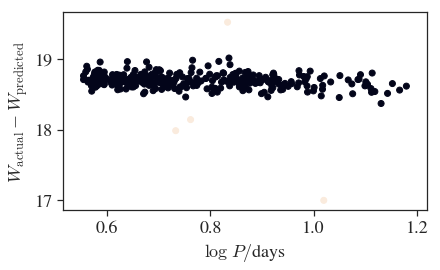

In [58]:
inliers = [True for ii in range(len(actual_Ws))]
while True:
    values = np.array(actual_Ws - ests[:,X_columns.index('W')])
    weights = 1. / np.sqrt( e_ests[:,X_columns.index('W')]**2 + e_actual_Ws**2 + 0.047**2 )**2
    
    average = np.average(values[inliers], weights=weights[inliers])
    variance = np.average((values-average)[inliers]**2, weights=weights[inliers])
    
    new_outliers = np.abs(values[inliers] - average)/np.sqrt(variance) > 5
    if not np.any(new_outliers):
        break
    inliers = np.logical_not(np.abs(values - average)/np.sqrt(variance) > 5)

print(average, '+/-', np.sqrt(variance))

plt.scatter(logPs, actual_Ws - ests[:,X_columns.index('W')], c=np.logical_not(inliers))
#plt.plot(np.array(logPs)[inlier_mask], np.array(actual_Ws - Ws)[inlier_mask], '.')
#plt.plot(np.array(logPs)[outlier_mask], np.array(actual_Ws - Ws)[outlier_mask], '.')

plt.xlabel('$\log\;P/$days')
plt.ylabel('$W_{\\rm{actual}} - W_{\\rm{predicted}}$')
plt.show()

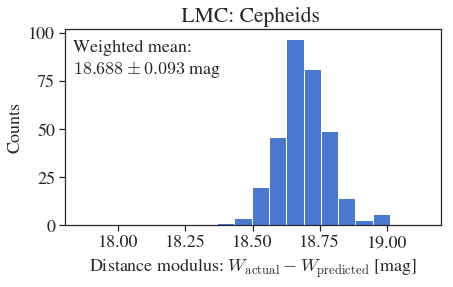

In [59]:
plt.suptitle('         LMC: Cepheids', y=0.99)
plt.hist(np.array(actual_Ws - ests[:,X_columns.index('W')])[inliers])
plt.xlabel('Distance modulus: $W_{\\rm{actual}} - W_{\\rm{predicted}}$ [mag]')
plt.ylabel('Counts')
plt.xlim([17.8, 19.2])
plt.text(17.83, 78, 'Weighted mean:\n$18.688 \pm 0.093$ mag')

plt.savefig('distance_modulus_hist.pdf')
plt.show()

Use random forests to obtain feature importances 

In [60]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['logL'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

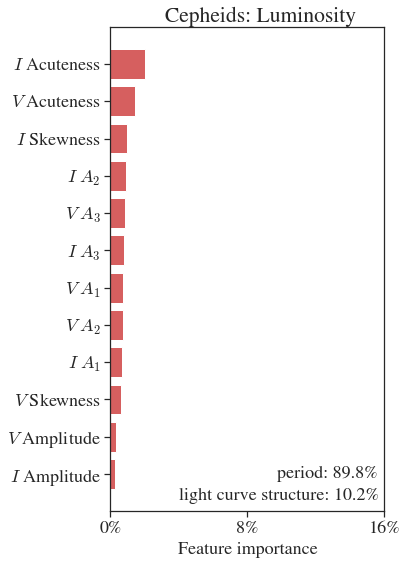

In [61]:
plt.figure(figsize=(6,8))
plt.suptitle('                     Cepheids: Luminosity', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.04,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('CEP-L-importances.pdf')
plt.show()

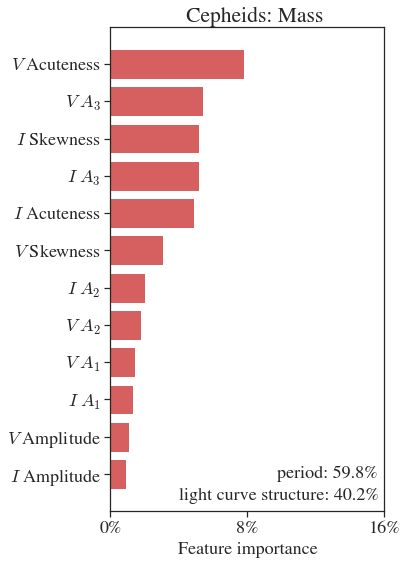

In [62]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['M'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                   Cepheids: Mass', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.04,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('CEP-M-importances.pdf')
plt.show()

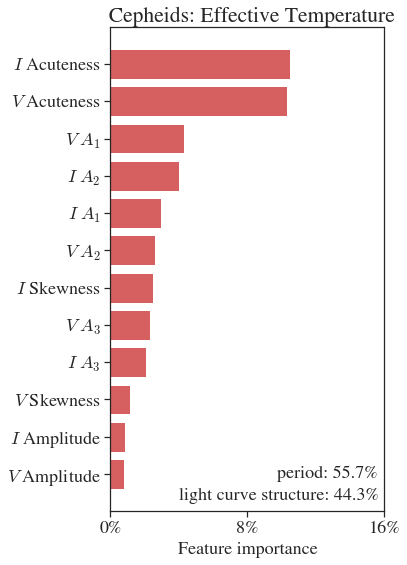

In [63]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['Teff'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                  Cepheids: Effective Temperature', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.04,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('CEP-Teff-importances.pdf')
plt.show()

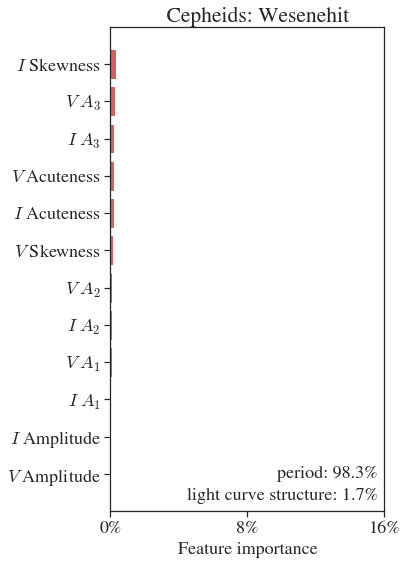

In [64]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['W'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                    Cepheids: Wesenehit', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.045,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('CEP-W-importances.pdf')
plt.show()

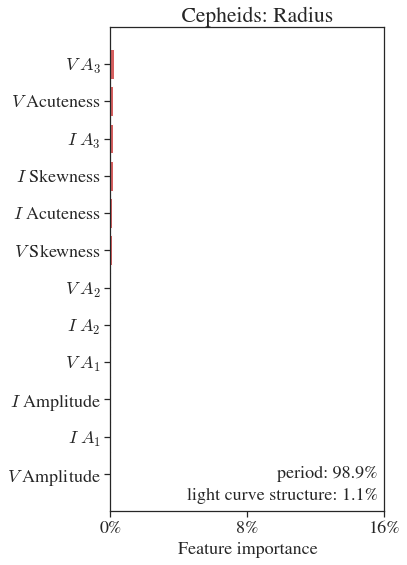

In [65]:
y_col_names = ['$\log\;P$', 
               '$I$ Amplitude', '$I$ Skewness', '$I$ Acuteness',
               '$V$ Amplitude', '$V$ Skewness', '$V$ Acuteness',
               '$I$ $A_1$', '$I$ $A_2$', '$I$ $A_3$',
               '$V$ $A_1$', '$V$ $A_2$', '$V$ $A_3$']

rf = RandomForestRegressor(n_estimators=1024, random_state=1)
X = DF[y_columns]
rf.fit(X, DF['logR'])

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)

plt.figure(figsize=(6,8))
plt.suptitle('                    Cepheids: Radius', y=0.99)
rects1 = plt.barh(range(X.shape[1])[:-1], importances[indices][:-1],
       color="r", #yerr=std[indices][1:], 
                  align="center")
plt.yticks(range(X.shape[1])[:-1], [y_col_names[idx] for idx in indices][:-1])#, rotation='vertical')
plt.ylim([-1, X.shape[1]-1])
plt.xlabel('Feature importance')

plt.xlim([0, 0.16])
ax = plt.gca()
ax.set_xticks([0, 0.08, 0.16])
ax.set_xticklabels(['0%', '8%', '16%'])

plt.text(0.0972, -0.1, 'period: %.1f%%' % (importances[0]*100))
plt.text(0.045,   -0.7, 'light curve structure: %.1f%%' % (sum(importances[1:])*100))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.1f' % (height*100) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.savefig('CEP-logR-importances.pdf')
plt.show()